# Machine Learning Model

This notebook develops a few machine learning model to forecast the time-series data provided by 'time_series.csv'. Time series are a form of sequential data, which makes recurrent neural networks suitable for the task. Various network architectures are considered, involving Conv1D, LSTM and/or Dense layers.

In [1]:
from scripts.temp_ml_scripts import *

## Load the time series

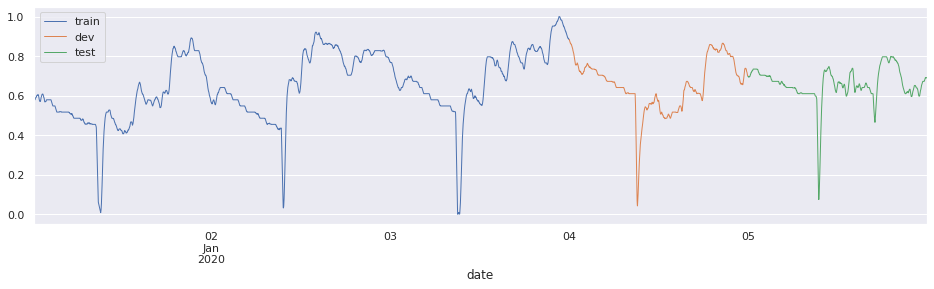

In [2]:
# Load time series data
time_series = pd.read_csv('data/time_series.csv', index_col='date').asfreq('T')['temp']

# Chop series for developing
time_series = time_series.loc['2020-01-01':'2020-01-05'] # 5 days

# Normalize the data (particlularly important for NNs)
min_value = np.min(time_series)
max_value = np.max(time_series)
time_series = (time_series - min_value)/(max_value - min_value)

def un_normalize_series(series):
    original = series * (max_value - min_value) + min_value
    return original
    
# Size of dev and test sets (in same units as time_series: minutes)
size_dev = 60 * 24 * 1 # one day
size_test = 60 * 24 * 1 # one day

# Split time series into train, dev and test sets
time_series_train, time_series_dev, time_series_test = train_dev_test_split(time_series, size_dev, size_test)  
# for implementation, see temp-utilities.py

# Plot the time series
plot_time_series(time_series_train, time_series_dev, time_series_test)  
# for implementation, see temp-utilities.py

## Train neural network

To train a neural network, it is required to construct a batch of input features `X` and a batch of output labels `y`.
For plotting the time-series, it will be convenient to keep track of time in `t` as well.

In [3]:
# Define the number of time steps fed into the model and the number of subsequent time steps predicted by the model
n_steps_in = 5     # this number will be varied as a model parameter
n_steps_out = 10   # this number will be kept constant to match the mathematical analysis in the notebook temp2-mathematical-models.ipynb

# Construct train, dev and test sets (X, y)
X_train, y_train, t_train = split_sequence(time_series_train, n_steps_in, n_steps_out)  # for implementation of split_sequence(), see temp-ml-scripts.py
X_dev, y_dev, t_dev = split_sequence(time_series_dev, n_steps_in, n_steps_out)
X_test, y_test, t_test = split_sequence(time_series_test, n_steps_in, n_steps_out)

print('train shapes (X,y,t) : ', X_train.shape, y_train.shape, t_train.shape)
print('dev shapes   (X,y,t) : ', X_dev.shape, y_dev.shape, t_dev.shape)
print('test shapes  (X,y,t) : ', X_test.shape, y_test.shape, t_test.shape)

train shapes (X,y,t) :  (4292, 5, 1) (4292, 10) (4292, 10)
dev shapes   (X,y,t) :  (1426, 5, 1) (1426, 10) (1426, 10)
test shapes  (X,y,t) :  (1426, 5, 1) (1426, 10) (1426, 10)


Define an initial model with two layers:

1. LSTM (Long Short-Term Memory) layer with `n_steps_in` one-dimensional input features and a 20-dimensional hidden state.
2. Dense layer with `n_steps_out` real numbers in its output.

In [4]:
# Define an initial model
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(20, activation='relu', input_shape=(n_steps_in, 1)),
    tf.keras.layers.Dense(n_steps_out, activation='linear')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                1760      
_________________________________________________________________
dense (Dense)                (None, 10)                210       
Total params: 1,970
Trainable params: 1,970
Non-trainable params: 0
_________________________________________________________________


The model contains a very modest number of O(2k) trainable parameters.

Next, the model is compiled to minimize the `'mean-squared-error'` loss function using the efficient adaptive `'adam'` optimizer.

A model checkpoint callback is used to store the version of the model (i.e. state of weights) that achieved the lowest dev loss.

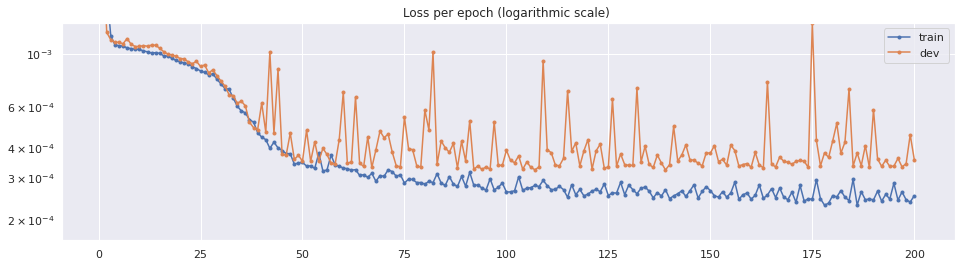

In [5]:
# Compile the model
model.compile(optimizer='adam', loss='mse')

# Callbacks
em = EpochMonitor()
mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', 
                                        monitor='val_loss', 
                                        mode='min', 
                                        verbose=0, 
                                        save_best_only=True)

# Train the model
training_history = model.fit(X_train, y_train, 
                             validation_data=(X_dev, y_dev), 
                             epochs=200, 
                             verbose=0, 
                             callbacks=[em, mc])

# Plot the loss during training
# for implementation of plot_training_loss(), see temp-ml-scripts.py
plot_training_loss(training_history, hide_first=2, lin=False)  

The train loss is decreasing with the number of epochs, and starting to level out, so that more training helps increasingly less.
The dev loss is larger than the train loss, as would be expected. 
The gap between the two remains roughly constant, indicating that no overfitting is likely to be taking place yet.

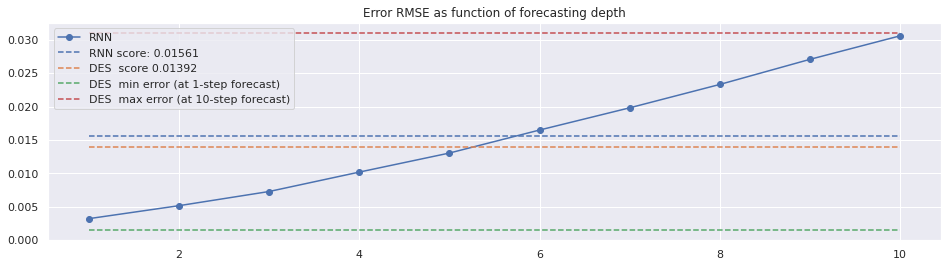

In [6]:
# Load best state of the model
best_model = tf.keras.models.load_model('best_model.h5')

# Forecasting
# for implementation of direct_forecast(), see temp-ml-scripts.py
forecast = direct_forecast(X_dev, y_dev, t_dev, best_model)  

# Scoring
# for implementation of evaluate_model_performance(), see temp-ml-scripts.py
errors, score = evaluate_model_performance(forecast)         

# Compare score to best model from preceding notebook
# for implementation of compare_score(), see temp-ml-scripts.py
compare_score(errors, score)                                 

This simple LSTM model already performs comparably to the best model from the previous notebook `temp2-mathematical-models.ipynb`. 
The challenge is to improve upon the present model through tuning of the model hyperparameters.

## Hyperparameter tuning

The hyperparameter tuning is set up as follows:
- Parameters and their ranges of values are specified in a dictionary `param_values`. These include fixed ('global') parameters `n_steps_out`, `min_n_epochs`, `max_n_epochs`, `patience` as well as variable parameters, such as `model_name`, `n_steps_in`, `hidden_dim`, ...
- A custom function `select_model()` defines models, which are selected with the parameter `model_name`.
- The training and evaluation of each model in the parameter search is carried out by the custom helper function `grid_search()`. Remarks: 
    - A `ModelCheckpoint()` callback is used to keep the best performance of each model on the dev set over the whole training.
    - A custom `EarlyStoppingAfter()` callback is used to train each model at least `min_n_epochs` epochs, after which the training is stopped once the dev loss has not lowered its all-time lowest value during the last `patience` epochs, or once `max_n_epochs` epochs have elapsed. This method allows for an efficient and reasonably fair comparison between models of different complexity, which require different amounts of training.

In [7]:
def grid_search(param_values):
    """
    Performs a grid search over the specified parameter ranges, training and evaluating an RNN in each instance
    
    Input: 
    param_values - dictionary with ('parameter name', [list of values]) key-values pairs, dict
    
    Output:
    table - record of input and output of each run, pandas.DataFrame
    """
    # Create a parameter grid
    param_grid = ParameterGrid(param_values)

    # Separate variable from constant parameters (for printing purpose)
    variable_param = dict()
    constant_param = dict()
    for (key,val) in param_values.items(): 
        if len(val)>1: 
            variable_param[key] = val
        else:
            constant_param[key] = val

    # Initialization
    results = []
    run = 1
    
    # Grid search
    for param in param_grid:
        time1 = datetime.now()
        # Select model
        model = select_model(param)
        # Compile model
        model.compile(optimizer='adam', loss='mse')
        # Callbacks
        em = EpochMonitor()
        es = EarlyStoppingAfter(monitor='val_loss', 
                                mode='min', 
                                verbose=0, 
                                patience=param['patience'], 
                                start_epoch=param['min_n_epochs'])
        mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', 
                                                monitor='val_loss', 
                                                mode='min', 
                                                verbose=0, 
                                                save_best_only=True)
        # Construct train, dev and test sets (X, y)
        X_train, y_train, t_train = split_sequence(time_series_train, param['n_steps_in'], param['n_steps_out'])
        X_dev, y_dev, t_dev = split_sequence(time_series_dev, param['n_steps_in'], param['n_steps_out'])
        # Train model
        train_hist = model.fit(X_train, y_train, 
                               validation_data=(X_dev, y_dev), 
                               epochs=param['max_n_epochs'], 
                               verbose=0, 
                               callbacks=[em, es, mc])
        train_hist = train_hist.history
        n_epochs = len(train_hist['loss'])
        # Load best state of the model
        best_model = tf.keras.models.load_model('best_model.h5')
        # Forecast
        # for implementation of direct_forecast(), see temp-ml-scripts.py
        forecast = direct_forecast(X_dev, y_dev, t_dev, best_model)  
        # Score
        # for implementation of evaluate_model_performance(), see temp-ml-scripts.py
        errors, score = evaluate_model_performance(forecast)  
        # Store result
        col = list(param.keys())
        col = col + ['neurons', 'n_epochs', 'train_hist', 'model', 'forecast', 'errors', 'score']
        res = list(param.values())
        res = res + [model.count_params(), n_epochs, train_hist, best_model, forecast, errors, score]
        results.append(res)
        time2 = datetime.now()
        deltat = time2 - time1
        print('{run:2}/{tot:2}   {time}   {epo:3} epochs {neu:7} neurons   score = {sco:.5}   {par}'.format(
            run=run,
            tot=len(param_grid),
            time=str(deltat).split('.', 2)[0],
            epo=n_epochs,
            neu=model.count_params(),
            sco=score,
            par={key:param[key] for key in variable_param.keys()}
        ))
        run=run+1
        
    # Collect result in a table and sort by score
    table = pd.DataFrame(np.array(results), columns=col)
    table = table.sort_values('score')
    return table

### Search 1: vary number of input steps and hidden dimension

The initial model features two key parameters that can be tuned: 
- the number of input time steps `n_steps_in`
- the dimension of the hidden state `hidden_dim`

The initial model uses the values `n_steps_in = 5` and `hidden_dim = 20` without motivation.
Here, both parameters are varied in search of a better performing model.

In [8]:
# Define models
def select_model(param):
    """
    Selects a model from a list of different neural networks
    """
    # The same model as defined above, but with adjustable parameters:
    if param['model_name'] == 'mod1': 
        model = tf.keras.models.Sequential([
            tf.keras.layers.LSTM(param['hidden_dim'], activation='relu', input_shape=(param['n_steps_in'], 1)),
            tf.keras.layers.Dense(param['n_steps_out'], activation='linear')
        ])
    return model

# Define parameter ranges
param_values = {
    # always keep fixed
    'n_steps_out' : [10],
    'min_n_epochs' : [200],
    'max_n_epochs' : [200],
    'patience' : [0],
    # keep fixed
    'model_name' : ['mod1'],
    # vary
    'n_steps_in': [3,5,10,20],
    'hidden_dim' : [20,40,60,80],
}

# Run search
search1 = grid_search(param_values)  # for implementation of grid_search(), see temp-ml-scripts.py
search1.to_csv('search1.csv')
search1[['neurons','n_epochs','n_steps_in','hidden_dim','score']]

 1/16   0:01:28   200 epochs    1970 neurons   score = 0.019467   {'n_steps_in': 3, 'hidden_dim': 20}
 2/16   0:01:54   200 epochs    1970 neurons   score = 0.015297   {'n_steps_in': 5, 'hidden_dim': 20}
 3/16   0:02:47   200 epochs    1970 neurons   score = 0.016801   {'n_steps_in': 10, 'hidden_dim': 20}
 4/16   0:04:36   200 epochs    1970 neurons   score = 0.014655   {'n_steps_in': 20, 'hidden_dim': 20}
 5/16   0:01:34   200 epochs    7130 neurons   score = 0.013973   {'n_steps_in': 3, 'hidden_dim': 40}
 6/16   0:01:57   200 epochs    7130 neurons   score = 0.016042   {'n_steps_in': 5, 'hidden_dim': 40}
 7/16   0:02:51   200 epochs    7130 neurons   score = 0.015274   {'n_steps_in': 10, 'hidden_dim': 40}
 8/16   0:04:52   200 epochs    7130 neurons   score = 0.013775   {'n_steps_in': 20, 'hidden_dim': 40}
 9/16   0:01:41   200 epochs   15490 neurons   score = 0.014903   {'n_steps_in': 3, 'hidden_dim': 60}
10/16   0:02:04   200 epochs   15490 neurons   score = 0.015454   {'n_steps_in

,neurons,n_epochs,n_steps_in,hidden_dim,score
14,27050,200,10,80,0.0130463
11,15490,200,20,60,0.0132082
15,27050,200,20,80,0.0132585
7,7130,200,20,40,0.0137749
4,7130,200,3,40,0.0139732
12,27050,200,3,80,0.0139952
10,15490,200,10,60,0.0144391
3,1970,200,20,20,0.014655
8,15490,200,3,60,0.0149026
6,7130,200,10,40,0.0152741


- Plot the results of each run
- Plot the training history of each run
- Plot the best score in comparison to the mathematical model

In [9]:
# Set data to plot
data = search1
best = data.iloc[0]

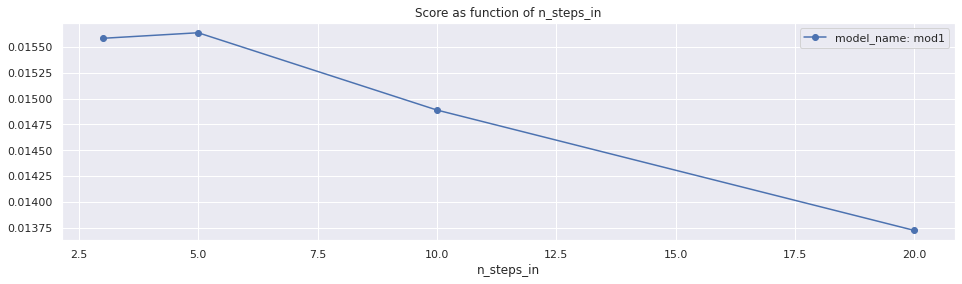

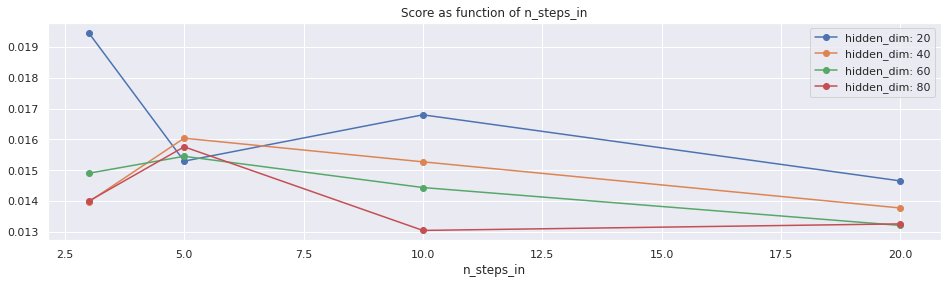

In [10]:
# Plot score vs n_steps_in
plot_score(data, variable='n_steps_in', category='model_name') # averaged over hidden_dim
plot_score(data, variable='n_steps_in', category='hidden_dim')

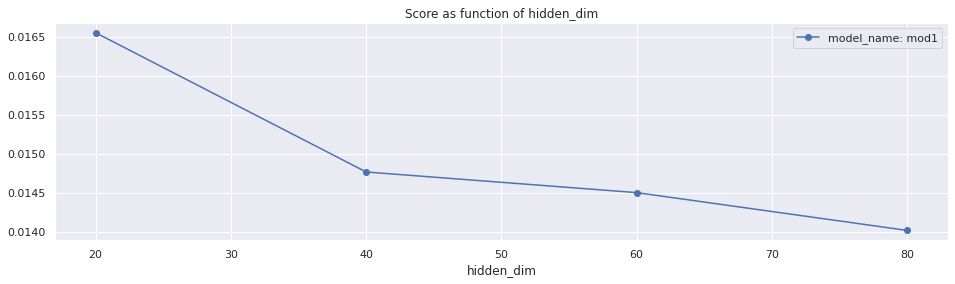

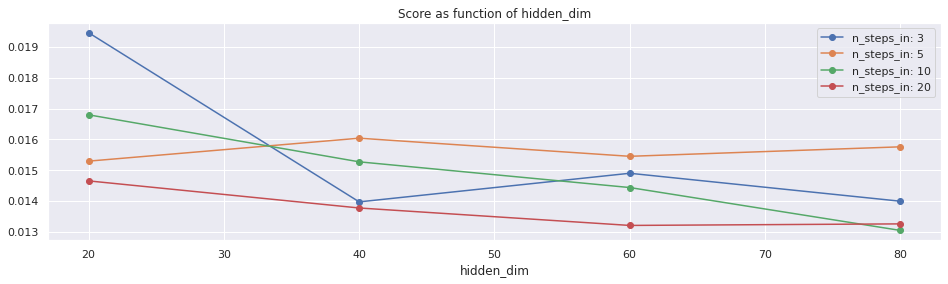

In [11]:
# Plot score vs hidden_dim
plot_score(data, variable='hidden_dim', category='model_name') # averaged over n_steps_in
plot_score(data, variable='hidden_dim', category='n_steps_in')

In [ ]:
# # Plot training histories
# labels = ['n_steps_in','hidden_dim']
# for i in range(len(data)):
#     title = ' run '+str(i+1)
#     for lab in labels: title=title+'   '+lab+': '+str(data[lab].loc[i])
#     plot_training_loss(data['train_hist'].loc[i], hide_first=2, title=title, lin=False)

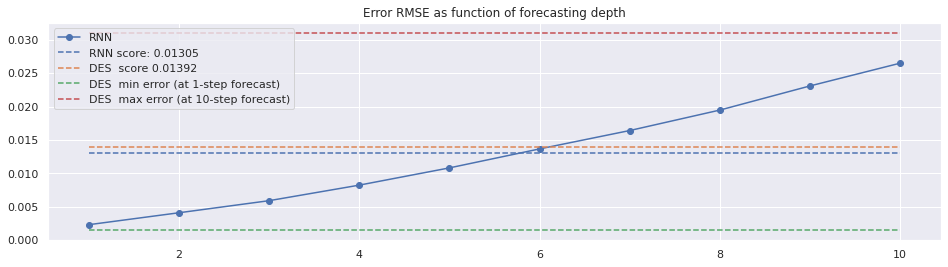

In [13]:
# Construct train and dev sets
X_train, y_train, t_train = split_sequence(time_series_train, best['n_steps_in'], best['n_steps_out'])
X_dev, y_dev, t_dev = split_sequence(time_series_dev, best['n_steps_in'], best['n_steps_out'])
# Forecasting and scoring
forecast = direct_forecast(X_dev, y_dev, t_dev, best['model'])  # for implementation of direct_forecast(), see temp-ml-scripts.py
errors, score = evaluate_model_performance(forecast)            # for implementation of evaluate_model_performance(), see temp-ml-scripts.py
compare_score(errors, score)                                    # for implementation of compare_score(), see temp-ml-scripts.py

In [14]:
# Best score (lowest) in current search
print('best score: ',best['score'])
print('n_steps_in: ',best['n_steps_in'])
print('hidden_dim: ',best['hidden_dim'])

best score:  0.013046260658448596
n_steps_in:  10
hidden_dim:  80


For the estimated best combination of `n_steps_out` and `hidden_dim`, this RNN model outperforms the mathematical DES model.

### Search 2: Vary architectures and number of input steps

Looking for better performance, a next step would be to change the neural network architecture itself.
In this search, three different architectures are considered, schematically:
- LSTM + Dense
- LSTM + LSTM + Dense
- Conv1D + LSTM + Dense

and each are considered with a few values of `n_steps_in`.

In [15]:
# Define models
def select_model(param):
    """
    Selects a model from a list of different neural networks
    """
    # Three different recurrent neural network architectures with a comparable number of neurons ~ O(30k-40k)
    # Same network architecture as above
    if param['model_name'] == 'mod1': 
        model = tf.keras.models.Sequential([
            tf.keras.layers.LSTM(100, activation='relu', input_shape=(param['n_steps_in'], 1)),
            tf.keras.layers.Dense(param['n_steps_out'], activation='linear')
        ])
    # Deeper network: stack of two LSTM layers
    if param['model_name'] == 'mod2': 
        model = tf.keras.models.Sequential([
            tf.keras.layers.LSTM(60, activation='relu', return_sequences=True, input_shape=(param['n_steps_in'], 1)),
            tf.keras.layers.LSTM(50, activation='relu'),
            tf.keras.layers.Dense(param['n_steps_out'], activation='linear')
        ])
    # Deeper network: preprocess input with Conv1D, before feeding into LSTM
    if param['model_name'] == 'mod3':
        model = tf.keras.models.Sequential([
            tf.keras.layers.Conv1D(filters=128, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape=(param['n_steps_in'], 1)),
            tf.keras.layers.LSTM(50, activation='relu'),
            tf.keras.layers.Dense(param['n_steps_out'], activation='linear')
        ])
    return model

for name in ['mod1','mod2','mod3']:
    print(name,select_model({'model_name':name,'n_steps_in':20,'n_steps_out':10}).count_params())

mod1 41810
mod2 37590
mod3 37078


In [16]:
# Define parameter ranges
param_values = {
    # always keep fixed
    'n_steps_out' : [10],
    'min_n_epochs' : [200],
    'max_n_epochs' : [200],
    'patience' : [0],
    # vary
    'model_name' : ['mod1','mod2','mod3'],
    'n_steps_in': [5,10,20]
}

# Run grid search
search2 = grid_search(param_values)
search2.to_csv('search2.csv')
search2[['neurons','n_epochs','model_name','n_steps_in','score']]

 1/ 9   0:02:41   200 epochs   41810 neurons   score = 0.015034   {'model_name': 'mod1', 'n_steps_in': 5}
 2/ 9   0:04:20   200 epochs   41810 neurons   score = 0.013529   {'model_name': 'mod1', 'n_steps_in': 10}
 3/ 9   0:07:33   200 epochs   41810 neurons   score = 0.012665   {'model_name': 'mod1', 'n_steps_in': 20}
 4/ 9   0:03:34   200 epochs   37590 neurons   score = 0.014552   {'model_name': 'mod2', 'n_steps_in': 5}
 5/ 9   0:05:39   200 epochs   37590 neurons   score = 0.012213   {'model_name': 'mod2', 'n_steps_in': 10}
 6/ 9   0:10:03   200 epochs   37590 neurons   score = 0.011758   {'model_name': 'mod2', 'n_steps_in': 20}
 7/ 9   0:02:23   200 epochs   37078 neurons   score = 0.013453   {'model_name': 'mod3', 'n_steps_in': 5}
 8/ 9   0:03:32   200 epochs   37078 neurons   score = 0.011682   {'model_name': 'mod3', 'n_steps_in': 10}
 9/ 9   0:05:51   200 epochs   37078 neurons   score = 0.011858   {'model_name': 'mod3', 'n_steps_in': 20}


,neurons,n_epochs,model_name,n_steps_in,score
7,37078,200,mod3,10,0.0116822
5,37590,200,mod2,20,0.0117579
8,37078,200,mod3,20,0.0118578
4,37590,200,mod2,10,0.0122131
2,41810,200,mod1,20,0.0126651
6,37078,200,mod3,5,0.0134535
1,41810,200,mod1,10,0.013529
3,37590,200,mod2,5,0.0145517
0,41810,200,mod1,5,0.0150335


- Plot the results of each run
- Plot the training history of each run
- Plot the best score in comparison to the mathematical model

In [17]:
# Set data to plot
data = search2
best = data.iloc[0]

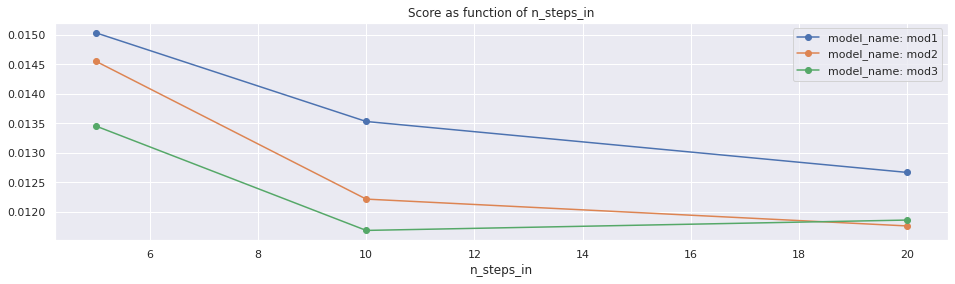

In [18]:
# Plot score vs model_name
plot_score(data, variable='n_steps_in', category='model_name')

In [ ]:
# # Plot training histories
# labels = ['model_name', 'n_steps_in']
# for i in range(len(data)):
#     title = ' run '+str(i+1)
#     for lab in labels: title=title+'   '+lab+': '+str(data[lab].loc[i])
#     plot_training_loss(data['train_hist'].loc[i], hide_first=2, title=title, lin=False)

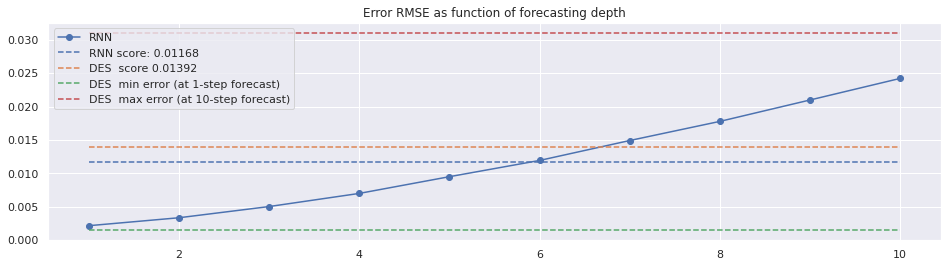

In [20]:
# Construct train and dev sets
X_train, y_train, t_train = split_sequence(time_series_train, best['n_steps_in'], best['n_steps_out'])
X_dev, y_dev, t_dev = split_sequence(time_series_dev, best['n_steps_in'], best['n_steps_out'])
# Forecasting and scoring
forecast = direct_forecast(X_dev, y_dev, t_dev, best['model'])  # for implementation of direct_forecast(), see temp-ml-scripts.py
errors, score = evaluate_model_performance(forecast)            # for implementation of evaluate_model_performance(), see temp-ml-scripts.py
compare_score(errors, score)                                    # for implementation of compare_score(), see temp-ml-scripts.py

In [21]:
# Best score (lowest) in current search
print('best score: ',best['score'])
print('model_name: ',best['model_name'])
print('n_steps_in: ',best['n_steps_in'])

best score:  0.011682168575362629
model_name:  mod3
n_steps_in:  10


The third model, Conv1D + LSTM + Dense, has shown significant performance improvement.

### Search 3: vary Conv1D model parameters: filters, input steps, kernel

This search focusses on the third model and attempts to optimize the parameters of the Conv1D layer
- filters
- input steps
- kernel size

In [22]:
# Define models
def select_model(param):
    """
    Selects a model from a list of different neural networks
    """
    # Conv1D + LSTM + Dense
    if param['model_name'] == 'mod3':
        model = tf.keras.models.Sequential([
            tf.keras.layers.Conv1D(filters=param['filters'], kernel_size=param['kernel'], strides=1, padding='causal', activation='relu', input_shape=(param['n_steps_in'], 1)),
            tf.keras.layers.LSTM(param['hidden_dim'], activation='relu'),
            tf.keras.layers.Dense(param['n_steps_out'], activation='linear')
        ])
    return model

In [23]:
# Define parameter ranges
param_values = {
    # always keep fixed
    'n_steps_out' : [10],
    'min_n_epochs' : [200],
    'max_n_epochs' : [400],
    'patience' : [50],
    # keep fixed
    'model_name' : ['mod3'],
    'hidden_dim' : [20],
    # vary
    'filters' : [32,64,128],
    'n_steps_in': [5,10,20],
    'kernel' : [3,5,10]
}

# Run grid search
search3 = grid_search(param_values)
search3.to_csv('search3.csv')
search3[['neurons','n_epochs','filters','n_steps_in','kernel','score']]

 1/27   0:03:59   400 epochs    4578 neurons   score = 0.012606   {'filters': 32, 'n_steps_in': 5, 'kernel': 3}
 2/27   0:04:58   332 epochs    4578 neurons   score = 0.011662   {'filters': 32, 'n_steps_in': 10, 'kernel': 3}
 3/27   0:09:46   400 epochs    4578 neurons   score = 0.011982   {'filters': 32, 'n_steps_in': 20, 'kernel': 3}
 4/27   0:03:53   400 epochs    4642 neurons   score = 0.013564   {'filters': 32, 'n_steps_in': 5, 'kernel': 5}
 5/27   0:05:55   400 epochs    4642 neurons   score = 0.011797   {'filters': 32, 'n_steps_in': 10, 'kernel': 5}
 6/27   0:07:06   284 epochs    4642 neurons   score = 0.012197   {'filters': 32, 'n_steps_in': 20, 'kernel': 5}
 7/27   0:03:53   400 epochs    4802 neurons   score = 0.013823   {'filters': 32, 'n_steps_in': 5, 'kernel': 10}
 8/27   0:05:22   353 epochs    4802 neurons   score = 0.012422   {'filters': 32, 'n_steps_in': 10, 'kernel': 10}
 9/27   0:08:10   326 epochs    4802 neurons   score = 0.012344   {'filters': 32, 'n_steps_in': 2

,neurons,n_epochs,filters,n_steps_in,kernel,score
25,13538,400,128,10,10,0.0113822
23,12898,281,128,20,5,0.011558
11,7266,257,64,20,3,0.0116181
1,4578,332,32,10,3,0.0116621
10,7266,342,64,10,3,0.0117389
19,12642,342,128,10,3,0.0117503
4,4642,400,32,10,5,0.011797
18,12642,400,128,5,3,0.011877
14,7394,373,64,20,5,0.0119194
22,12898,290,128,10,5,0.011943


- Plot the results of each run
- Plot the training history of each run
- Plot the best score in comparison to the mathematical model

In [24]:
# Set data to plot
data = search3
best = data.iloc[0]

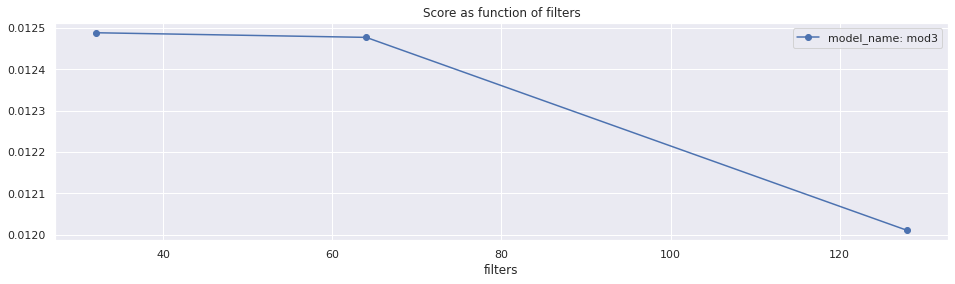

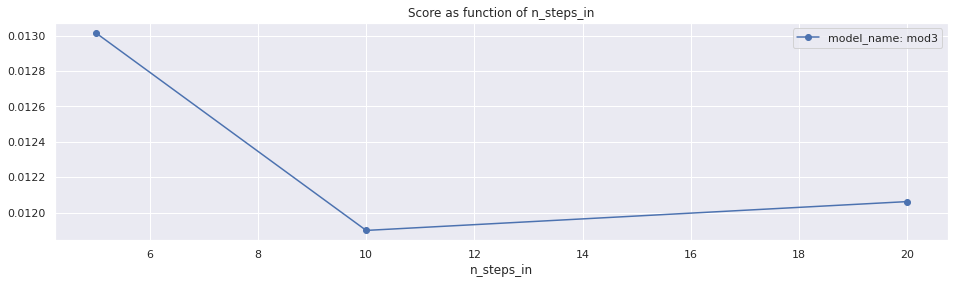

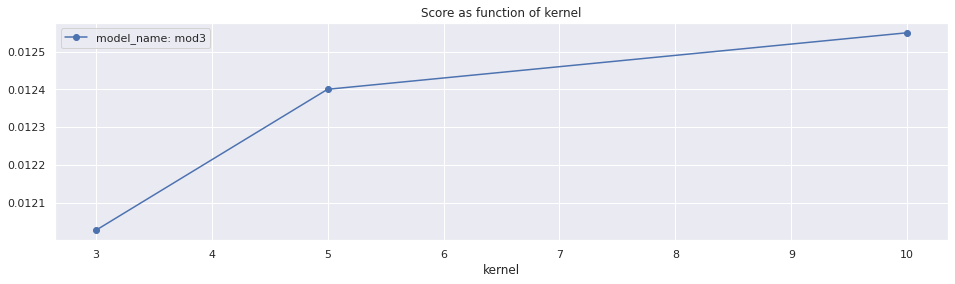

In [25]:
# Plot score
plot_score(data, variable='filters', category='model_name') # averaged over n_steps_in and kernel
plot_score(data, variable='n_steps_in', category='model_name') # averaged over filters and kernel
plot_score(data, variable='kernel', category='model_name') # averaged over filters and n_steps_in

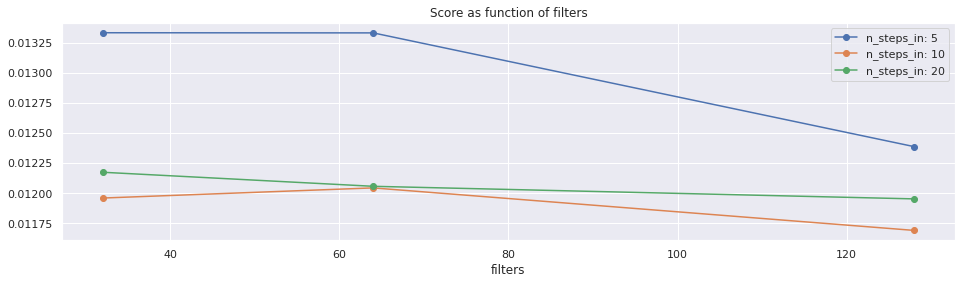

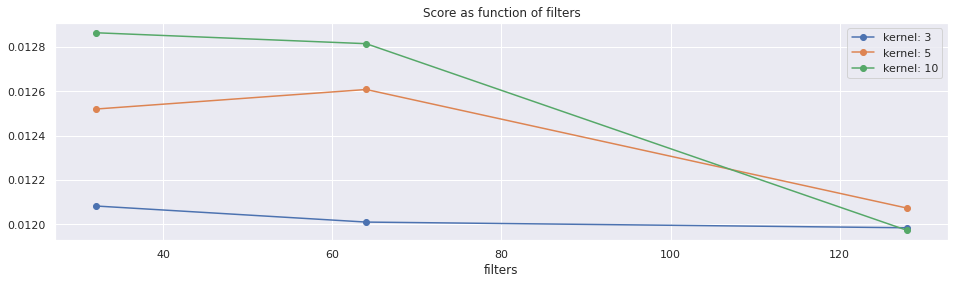

In [26]:
# More precise plots
plot_score(data, variable='filters', category='n_steps_in') # averaged over kernel
plot_score(data, variable='filters', category='kernel') # averaged over n_steps_in

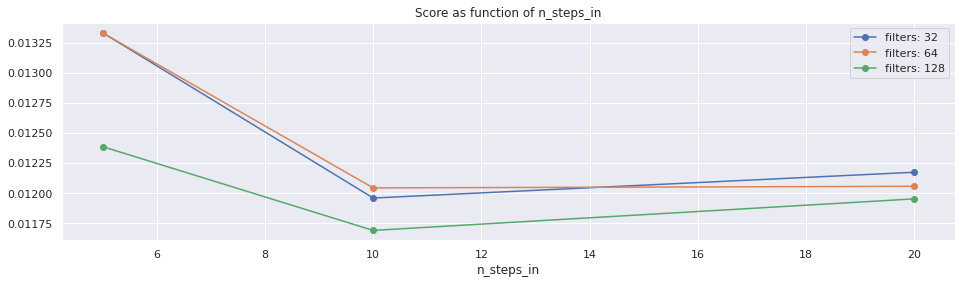

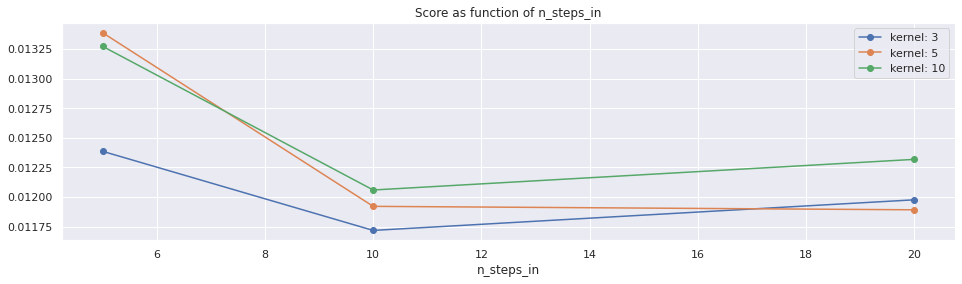

In [27]:
# More precise plots
plot_score(data, variable='n_steps_in', category='filters') # averaged over kernel
plot_score(data, variable='n_steps_in', category='kernel') # averaged over filters

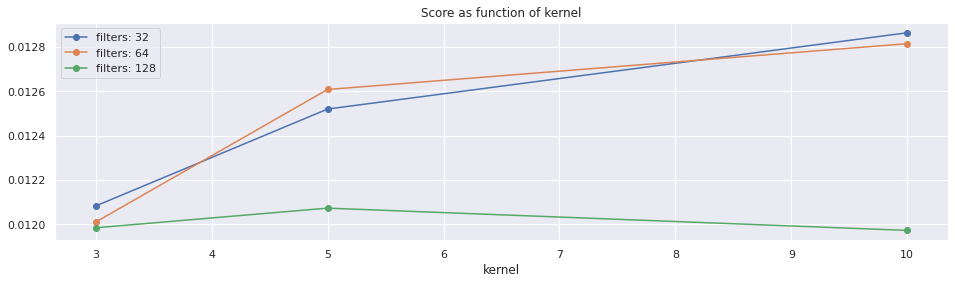

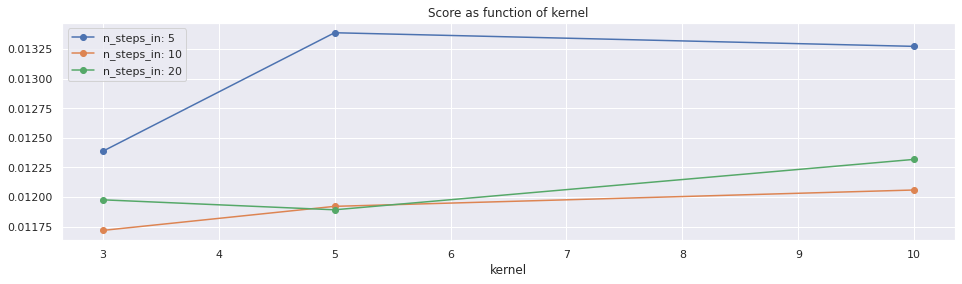

In [28]:
# More precise plots
plot_score(data, variable='kernel', category='filters') # averaged over n_steps_in
plot_score(data, variable='kernel', category='n_steps_in') # averaged over filters

In [29]:
# # Plot training histories
# labels = ['filters', 'n_steps_in', 'kernel']
# for i in range(len(data)):
#     title = ' run '+str(i+1)
#     for lab in labels: title=title+'   '+lab+': '+str(data[lab].loc[i])
#     plot_training_loss(data['train_hist'].loc[i], hide_first=2, title=title, lin=False)

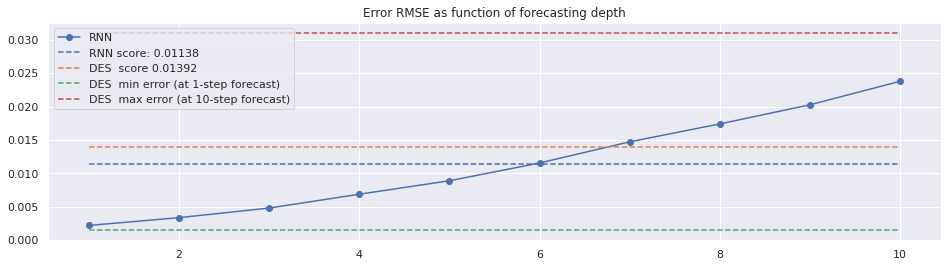

In [30]:
# Construct train and dev sets
X_train, y_train, t_train = split_sequence(time_series_train, best['n_steps_in'], best['n_steps_out'])
X_dev, y_dev, t_dev = split_sequence(time_series_dev, best['n_steps_in'], best['n_steps_out'])
# Forecasting and scoring
forecast = direct_forecast(X_dev, y_dev, t_dev, best['model'])  # for implementation of direct_forecast(), see temp-ml-scripts.py
errors, score = evaluate_model_performance(forecast)            # for implementation of evaluate_model_performance(), see temp-ml-scripts.py
compare_score(errors, score)                                    # for implementation of compare_score(), see temp-ml-scripts.py

In [31]:
# Best score (lowest) in current search
print('best score: ',best['score'])
print('model_name: ',best['model_name'])
print('filters: ',best['filters'])
print('n_steps_in: ',best['n_steps_in'])
print('kernel: ',best['kernel'])

best score:  0.011382175017157109
model_name:  mod3
filters:  128
n_steps_in:  10
kernel:  10


After this parameter search, it is time to select the best model and demonstrate its performance.

## Demonstration of best model

Load the best model from all runs in all searches

In [32]:
searches = [search1, search2, search3]
best_score = 999
for search in searches:
    cand = search.iloc[0]
    print('>',cand['score'])
    if cand['score'] < best_score:
        best_score = cand['score']
        best = cand
        
print('\nBest score: ',best_score)
print('\nModel details:\n'+str(best.iloc[:-5]))

> 0.013046260658448596
> 0.011682168575362629
> 0.011382175017157109

Best score:  0.011382175017157109

Model details:
filters           128
hidden_dim         20
kernel             10
max_n_epochs      400
min_n_epochs      200
model_name       mod3
n_steps_in         10
n_steps_out        10
patience           50
neurons         13538
n_epochs          400
Name: 25, dtype: object


In [33]:
best_model = best['model']
n_steps_in = best['n_steps_in']
n_steps_out = best['n_steps_out']

best_model.save('selected_best_model.h5')

# Construct dev and test sets
X_dev, y_dev, t_dev = split_sequence(time_series_dev, n_steps_in, n_steps_out)
X_test, y_test, t_test = split_sequence(time_series_test, n_steps_in, n_steps_out)

# Demonstrate model on test set
past = time_series_dev.iloc[-n_steps_out:]                      # past = last steps of dev...
past = past.append(time_series_test.iloc[:n_steps_out])         # ... and first steps of test
past = un_normalize_series(past)                                # un-normalize to degree Centigrade

# Forecasting
forecast = direct_forecast(X_test, y_test, t_test, best_model)  # for implementation of direct_forecast(), see temp-ml-scripts.py
forecast = un_normalize_series(forecast)                        # un-normalize to degree Centigrade

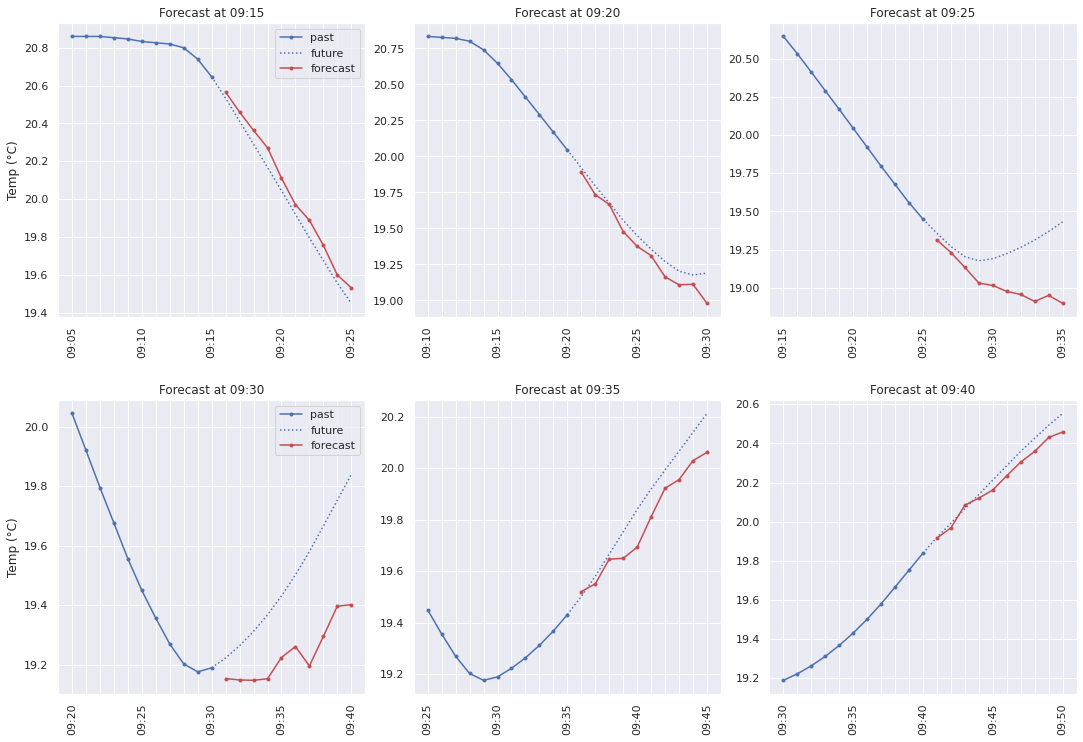

In [34]:
# Forecasting in a valley
Demonstration(past, forecast, cols=3, rows=2, start=557-10, step=5)

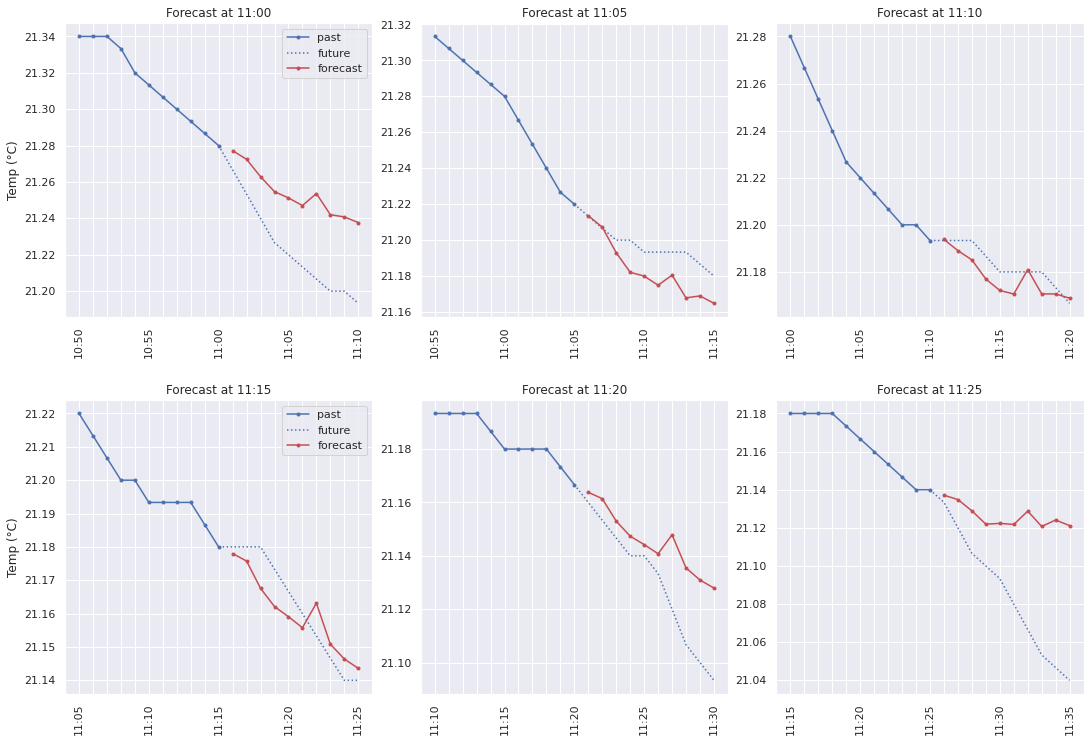

In [35]:
# Forecasting on a bumpy downhill slope
Demonstration(past, forecast, cols=3, rows=2, start=662-10, step=5)